## Load data

In [2]:
import numpy as np
import _pickle as pkl
import torch
from torchvision import transforms
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import os, sys, time
sys.path.append('..')
from utils import (set_seed_torch, Normalize)
set_seed_torch(3)

In [4]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({'res': 64,
 'dataset_path': '/media/m2-drive/datasets/pendulum-srl-sim/{}'
                   .format("pendulum64_total_2048_traj_16_repeat_2_with_angle_train.pkl"),
 'models_path': '/home/olimoyo/latent-metric-control/saved_models/{}'
                   .format("05-06-20_17:59:38_traj32_base_latent_bnFalse"),
 'device': 'cuda:0',
 'batch_size': 1,
 'n_frames_init': 4,
 'n_prediction': 11,
})

In [5]:
with open(args.dataset_path, 'rb') as f:
    data = pkl.load(f)
    
imgs_cached, actions, gt_state = data[0], data[1], data[2]
imgs_cached = imgs_cached.reshape(imgs_cached.shape[0], imgs_cached.shape[1], args.res, args.res, 3)
imgs = torch.empty((imgs_cached.shape[0], imgs_cached.shape[1], 1, 
                    imgs_cached.shape[2], imgs_cached.shape[3]), device=args.device)
actions = torch.from_numpy(actions).to(device=args.device)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    Normalize(mean=0.27, var=1.0 - 0.27) # 64x64
    ])
        
for ii in range(imgs_cached.shape[0]):
    for jj in range(imgs_cached.shape[1]):
        imgs[ii, jj, :, :, :] = t(imgs_cached[ii, jj, :, :, :])

## Visualize

In [3]:
from utils import load_models
from argparse import Namespace
import json
import torch.nn as nn

Loading models in path:  /home/olimoyo/robust-latent-srl/srl/saved_models/pendulum/uni/traj16_constant_no_BN/01-15-20_20:36:07_traj16_constant_no_BN


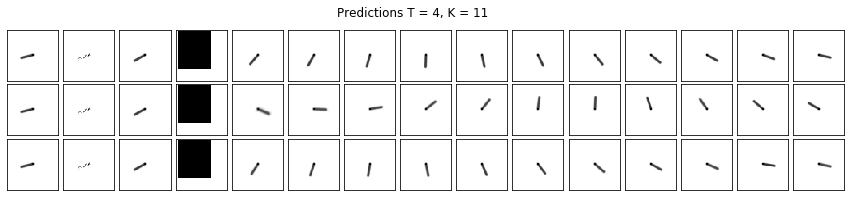

In [17]:
path_list = []
args_list = []

for filedir in os.listdir(args.models_path):
    fullpath_filedir = os.path.join(args.models_path, filedir)
    if os.path.isdir(fullpath_filedir):
        path_list.append(fullpath_filedir)
        with open(os.path.join(fullpath_filedir, 'hyperparameters.txt'), 'r') as fp:
            args_dict = json.load(fp)
        args_list.append(Namespace(**args_dict))

with torch.no_grad():
    for path, args in zip(path_list, args_list):

        enc, dec, lgssm = load_models(path, args, device=args.device)
        
        i = np.random.randint(imgs.shape[0] // BS)
        output_nl = None if args.use_binary_ce else nn.Sigmoid()

        # Prediction
        x_i = imgs[BS*i:BS*(i+1), :T] # each [x0, ..., x_{T-1}], torch.Size([BS, T, 16, 16])
        x = imgs[BS*i:BS*(i+1), T:(T+pred_len)]
        u = actions[BS*i:BS*(i+1), 1:(T+1), :] # each [u_1, ..., u_T], torch.Size([BS, 15, 1])
        u_f = actions[BS*i:BS*(i+1), (T+1):(T+pred_len), :] # [u_T, ..., u_{T+pred_len}]
        
        #TODO: Roll out
        
        # Plotting
        for bb in range(BS):
            columns = T + pred_len
            rows = 2
            fig=plt.figure(figsize=(15, 3))
            fig.suptitle('Predictions T = {}, K = {}'.format(T, pred_len))
            for ii in range(columns*rows):
                if ii<((columns*rows)/2):
                    img = x[bb,ii,0,:,:]
                else:
                    idx = int(ii-((columns*rows)/2))
                    if idx < T:
                        img = np.zeros((RES,RES))
                    else:
                        img = x_hat[bb,idx-2,0,:,:]
                fig.add_subplot(rows, columns, ii+1)
                plt.imshow(img, cmap="gray")
                plt.axis('off')
            plt.subplots_adjust(wspace=0.1, hspace=0)
            plt.show()

### Video

In [ ]:
video = x_pred[0].transpose(0, 2, 3, 1)
fig = plt.figure()
im = plt.imshow(video[0,:,:,0], cmap='gray')
plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,0])

def animate(i):
    im.set_data(video[i,:,:,0])
    return im

pred = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=100)
HTML(pred.to_html5_video())

In [ ]:
gt_video = x_pred_gt[0].transpose(0, 2, 3, 1)
fig = plt.figure()
im = plt.imshow(gt_video[0,:,:,0], cmap='gray')
plt.close() # this is required to not display the generated image

def init():
    im.set_data(gt_video[0,:,:,0])

def animate(i):
    im.set_data(gt_video[i,:,:,0])
    return im

gt = animation.FuncAnimation(fig, animate, init_func=init, frames=gt_video.shape[0],
                               interval=100)
HTML(gt.to_html5_video())